<a href="https://colab.research.google.com/github/Zurthr/SG-HDB-Flat-Resell-Prices/blob/affordability/Affordability_Level_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
df['month'] = pd.to_datetime(df['month'], errors='coerce')
cluster_df = df[['month','block','street_name','flat_type', 'resale_price', 'floor_area_sqm']].copy()
le = LabelEncoder()
cluster_df.dropna(inplace=True)
cluster_df.isna().sum()
cluster_df['flat_type_encoded'] = le.fit_transform(cluster_df['flat_type'])


scaler = StandardScaler()
features = scaler.fit_transform(cluster_df[['flat_type_encoded', 'resale_price', 'floor_area_sqm']])

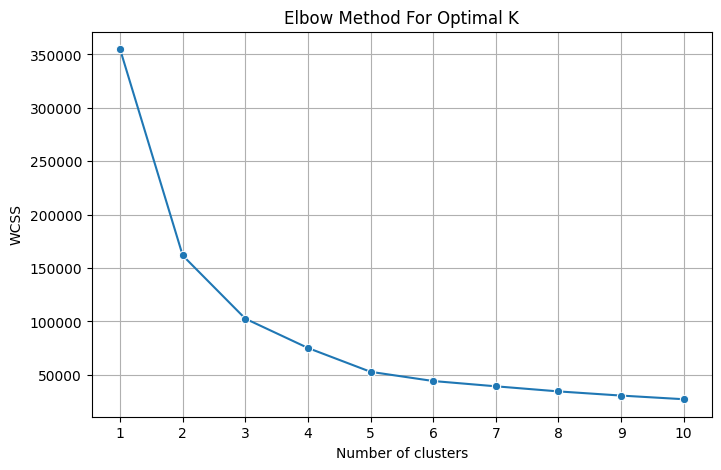

In [3]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 11), y=wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [4]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_df['affordability_level'] = kmeans.fit_predict(features)

# Map clusters to levels 1 (most affordable) to 5 (least affordable)
# Sort by average resale price in each cluster
cluster_means = cluster_df.groupby('affordability_level')['resale_price'].mean().sort_values().reset_index()
cluster_means['level'] = range(1, 6)

# Merge back
level_map = dict(zip(cluster_means['affordability_level'], cluster_means['level']))
cluster_df['affordability_level'] = cluster_df['affordability_level'].map(level_map)


In [5]:
print(cluster_df)


            month block        street_name  flat_type  resale_price  \
0      2017-01-01   406  ANG MO KIO AVE 10     2 ROOM      232000.0   
1      2017-01-01   108   ANG MO KIO AVE 4     3 ROOM      250000.0   
2      2017-01-01   602   ANG MO KIO AVE 5     3 ROOM      262000.0   
3      2017-01-01   465  ANG MO KIO AVE 10     3 ROOM      265000.0   
4      2017-01-01   601   ANG MO KIO AVE 5     3 ROOM      265000.0   
...           ...   ...                ...        ...           ...   
118284 2022-05-01   665          JLN DAMAI  EXECUTIVE      930000.0   
118285 2022-06-01   535     BEDOK NTH ST 3     2 ROOM      255000.0   
118286 2022-06-01   501     BEDOK NTH ST 3     3 ROOM      293000.0   
118287 2022-06-01     2    BEDOK STH AVE 1     3 ROOM      300000.0   
118288 2022-06-01    74       BEDOK NTH RD     3 ROOM      300500.0   

        floor_area_sqm  flat_type_encoded  affordability_level  
0                 44.0                  1                    1  
1                

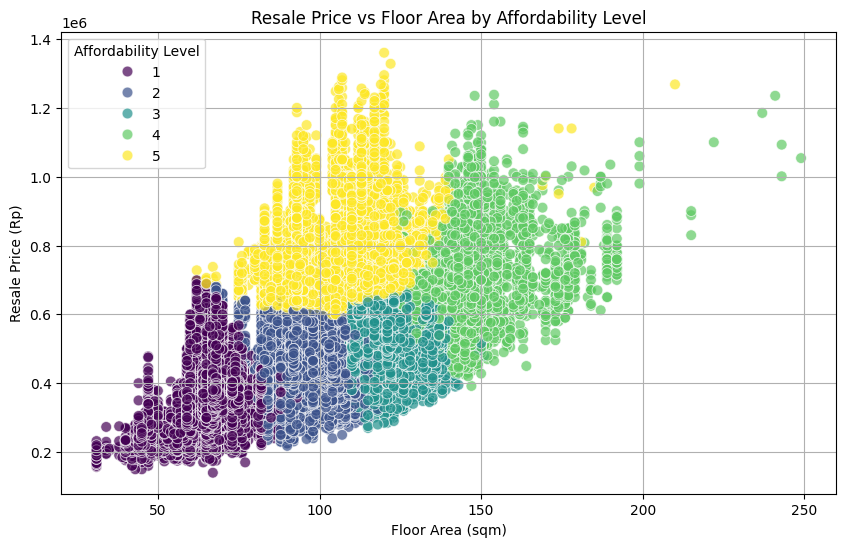

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cluster_df,
    x='floor_area_sqm',
    y='resale_price',
    hue='affordability_level',
    palette='viridis',
    alpha=0.7,
    s=60
)
plt.title('Resale Price vs Floor Area by Affordability Level')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (Rp)')
plt.legend(title='Affordability Level')
plt.grid(True)
plt.show()



In [7]:
# Assuming df_affordability contains the affordability levels
cluster_df.to_csv('affordability_levels.csv', index=False)
